In [1]:
import os
import numpy as np
import pandas as pd
import utils
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

# BRAIN PREPROCESSING

In [2]:
valbase = '/storage/gablab001/data/genus/current/structured/validate'

# 183_cor_subcor_D_thickness.csv contains the 170 features for the validation set
valdatacob = '183_cor_subcor_D_thickness.csv'
valdatacob = pd.read_csv(os.path.join(valbase, valdatacob))

# the file containing the covariates
valcov = pd.read_csv(os.path.join(valbase, '183_covariates_to_use.csv'))

# this is y in the classification analysis
valres = valcov['diag'].values

txtb = '/storage/gablab001/data/genus/current/structured/genus/text_files_for_indexing'
    
# directory to where the genus brain that is
bd = '/storage/gablab001/data/genus/current/structured/brain/'

# the header text file for the 170 columns, this will be used to subset the 
# entire genus data
thickness = np.genfromtxt(os.path.join(txtb, '170_columns.txt'), dtype=str)

# making equivalent volume headers from the thickness headers
volume = ' '.join(thickness).replace('thickness_D','volume_D').split(' ')

# this variable is for convenience so that i dont hav to change
# where the headers are in multiple places, just here
colheads = thickness

# loading the covariate headers that will be one hot encoded
cvar_encode = np.genfromtxt(os.path.join(txtb, 'covars_ecn.txt'), dtype=str)

# the covariate headers that wont be one hot encoded
cvar = np.genfromtxt(os.path.join(txtb, 'covars_no_ecn.txt'), dtype=str)

# GENUS brain data
brain = pd.read_csv(os.path.join(bd, 'GENUS_FS_ATLAS_D.csv'), low_memory=False)

# GENUS response variable
response = brain[['IID','GROUP']]

# here i combined all the needed data so that I can drop rows all together and 
# make sure all parts of the data, brain regions, covariates, ID, response are
# sorted by the same rows
combined = pd.concat([
    brain[colheads],
    brain[cvar],
    brain[cvar_encode],
    brain[['IID','GROUP']]
], axis=1).dropna().drop_duplicates('IID')

# getting the covariates that wont be one hot encoded
cvar_ne = combined[cvar].reset_index(drop=True)

# and the covariates that will be one hot encoded
cvar_e = combined[cvar_encode].reset_index(drop=True)

# performing one hot encoding
cvar_e = pd.concat([
    pd.DataFrame(utils.encoder(cvar_e[col])) for col in cvar_e.columns
], axis=1, ignore_index=True)

# recombining covariates
cvars = pd.concat([cvar_ne, cvar_e], axis=1)

# COGNITIVE DOMAINS PREPROCESSING

In [3]:
# load and read the data
cog_base = '/storage/gablab001/data/genus/current/structured/cognitive'
cog_file = 'GENUS_neuropsych_data_Domain_Scores.csv'
cog = pd.read_csv(os.path.join(cog_base, cog_file))

# load the fam file to assign diagnosis
fam_file = '/storage/gablab001/data/genus/current/structured/fam/FAM_N5338_EUR.csv'
fam = pd.read_csv(fam_file)

# match them on ids
ids = np.intersect1d(cog.IID.values, fam.IID.values)

# subset each dataset on the matched ids
fam_reduced = fam.set_index('IID').loc[ids].reset_index().drop_duplicates('IID')
cog_reduced = cog.set_index('IID').loc[ids].reset_index().drop_duplicates('IID')

# add sex and diagnosis to the cog data
# 1 is patient 0 is control
cog_reduced['GROUP'] = fam_reduced.affected.values - 1
cog_reduced['SEX'] = fam_reduced.sex.values

# removing these because they have to many missing values
scores_to_remove = 'NVLMdomainAvgZ ATVIdomainAvgZ NVWMdomainAvgZ'.split(' ')
five_scores = np.setdiff1d(utils.domain_scores, scores_to_remove).tolist() 
cog_five_scores = cog_reduced[five_scores + ['GROUP','SEX','IID']].dropna()

# COMBINING COG AND BRAIN DATA

In [ ]:
ids = np.intersect1d(cog_five_scores.IID.values, combined.IID.values)
print(ids.shape)

In [9]:
pwd

u'/storage/gablab001/data/genus/GIT/genus/notebooks'

In [5]:
cog_data = cog_five_scores.set_index('IID').loc[ids].reset_index()
genus_data = combined.set_index('IID').loc[ids].reset_index()

In [6]:
cog_data.head()

,IID,RPSdomainAvgZ,SOPdomainAvgZ,VISPAdomainAvgZ,VLMdomainAvgZ,VWMdomainAvgZ,GROUP,SEX
0,32-1-2-00-009,-0.137259,0.261825,0.576001,-0.633401,0.317417,1,1
1,32-1-2-00-010,-0.596795,-0.244088,0.435217,-0.356669,-0.625201,1,2
2,32-1-2-00-018,0.970423,-0.155064,1.014507,-1.006689,0.371461,1,1
3,32-1-2-00-022,-0.667989,-0.081110,-0.300298,0.048958,0.626954,1,1
4,32-1-2-00-026,-0.315741,-0.523805,0.984547,-1.323432,-1.114922,1,1


In [7]:
genus_data.head()

,IID,rh_G_and_S_frontomargin_thickness_D,lh_G_and_S_frontomargin_thickness_D,rh_G_and_S_occipital_inf_thickness_D,lh_G_and_S_occipital_inf_thickness_D,rh_G_and_S_paracentral_thickness_D,lh_G_and_S_paracentral_thickness_D,rh_G_and_S_subcentral_thickness_D,lh_G_and_S_subcentral_thickness_D,rh_G_and_S_transv_frontopol_thickness_D,...,lh_Amygdala,SEX,EstimatedTotalIntraCranialVol,AGE_MRI,HANDED,FS_VERSION,SOFT_VERS,HEAD_COIL_NCHANNELS,MAGN_FIELD_STR,GROUP
0,32-1-2-00-009,2.313,2.290,2.414,2.052,2.097,2.214,2.458,2.589,2.543,...,1315.1,1.0,1.590706e+06,21.0,Right,FS5.3,GE,8,3T,Schizophrenia
1,32-1-2-00-010,2.506,2.501,2.547,2.193,2.457,2.477,2.606,2.493,2.508,...,1291.2,0.0,1.546777e+06,20.0,Right,FS5.3,GE,8,3T,Schizophrenia
2,32-1-2-00-018,2.110,1.891,2.531,2.457,2.299,2.342,2.659,2.887,2.331,...,1457.0,1.0,1.604038e+06,27.0,Left,FS5.3,GE,8,3T,Schizophrenia
3,32-1-2-00-022,2.432,2.250,2.463,2.141,2.448,2.302,2.619,2.876,2.513,...,1278.8,1.0,1.439026e+06,20.0,Right,FS5.3,GE,8,3T,Schizophrenia
4,32-1-2-00-026,2.295,1.994,2.488,2.624,2.332,2.425,2.810,2.822,2.510,...,1302.3,1.0,1.547894e+06,31.0,Right,FS5.3,GE,8,3T,Schizophrenia


In [8]:
genus_y = np.array([1 if i == 'Schizophrenia' else 0 for i in genus_data.GROUP.values])

In [9]:
# QA check
(genus_y == cog_data.GROUP).mean()

1.0

In [10]:
brain_cog = pd.concat([
    genus_data,
    cog_data
], axis=1)

In [11]:
brain_cog.head()

,IID,rh_G_and_S_frontomargin_thickness_D,lh_G_and_S_frontomargin_thickness_D,rh_G_and_S_occipital_inf_thickness_D,lh_G_and_S_occipital_inf_thickness_D,rh_G_and_S_paracentral_thickness_D,lh_G_and_S_paracentral_thickness_D,rh_G_and_S_subcentral_thickness_D,lh_G_and_S_subcentral_thickness_D,rh_G_and_S_transv_frontopol_thickness_D,...,MAGN_FIELD_STR,GROUP,IID,RPSdomainAvgZ,SOPdomainAvgZ,VISPAdomainAvgZ,VLMdomainAvgZ,VWMdomainAvgZ,GROUP,SEX
0,32-1-2-00-009,2.313,2.290,2.414,2.052,2.097,2.214,2.458,2.589,2.543,...,3T,Schizophrenia,32-1-2-00-009,-0.137259,0.261825,0.576001,-0.633401,0.317417,1,1
1,32-1-2-00-010,2.506,2.501,2.547,2.193,2.457,2.477,2.606,2.493,2.508,...,3T,Schizophrenia,32-1-2-00-010,-0.596795,-0.244088,0.435217,-0.356669,-0.625201,1,2
2,32-1-2-00-018,2.110,1.891,2.531,2.457,2.299,2.342,2.659,2.887,2.331,...,3T,Schizophrenia,32-1-2-00-018,0.970423,-0.155064,1.014507,-1.006689,0.371461,1,1
3,32-1-2-00-022,2.432,2.250,2.463,2.141,2.448,2.302,2.619,2.876,2.513,...,3T,Schizophrenia,32-1-2-00-022,-0.667989,-0.081110,-0.300298,0.048958,0.626954,1,1
4,32-1-2-00-026,2.295,1.994,2.488,2.624,2.332,2.425,2.810,2.822,2.510,...,3T,Schizophrenia,32-1-2-00-026,-0.315741,-0.523805,0.984547,-1.323432,-1.114922,1,1


In [12]:
cog_data[five_scores]

,RPSdomainAvgZ,SOPdomainAvgZ,VISPAdomainAvgZ,VLMdomainAvgZ,VWMdomainAvgZ
0,-0.137259,0.261825,0.576001,-0.633401,0.317417
1,-0.596795,-0.244088,0.435217,-0.356669,-0.625201
2,0.970423,-0.155064,1.014507,-1.006689,0.371461
3,-0.667989,-0.081110,-0.300298,0.048958,0.626954
4,-0.315741,-0.523805,0.984547,-1.323432,-1.114922
5,0.318492,0.053449,1.236995,0.244592,0.687638
6,-0.652069,-0.636629,-0.776559,-0.992831,-0.631376
7,-0.045267,-0.372114,1.696646,-0.632695,-1.226413
8,-0.158079,0.044732,1.148695,-0.886437,0.311585
9,-1.127706,-0.877088,-0.291401,0.778301,-2.388255


In [13]:
genus_data[thickness]

,rh_G_and_S_frontomargin_thickness_D,lh_G_and_S_frontomargin_thickness_D,rh_G_and_S_occipital_inf_thickness_D,lh_G_and_S_occipital_inf_thickness_D,rh_G_and_S_paracentral_thickness_D,lh_G_and_S_paracentral_thickness_D,rh_G_and_S_subcentral_thickness_D,lh_G_and_S_subcentral_thickness_D,rh_G_and_S_transv_frontopol_thickness_D,lh_G_and_S_transv_frontopol_thickness_D,...,rh_Caudate,lh_Caudate,rh_Lateral.Ventricle,lh_Lateral.Ventricle,rh_Inf.Lat.Vent,lh_Inf.Lat.Vent,rh_Thalamus.Proper,lh_Thalamus.Proper,rh_Amygdala,lh_Amygdala
0,2.313,2.290,2.414,2.052,2.097,2.214,2.458,2.589,2.543,2.237,...,3580.0,3378.1,13852.1,24116.1,365.9,738.5,7069.7,7220.4,1573.9,1315.1
1,2.506,2.501,2.547,2.193,2.457,2.477,2.606,2.493,2.508,2.611,...,4294.4,4033.4,2046.5,1764.3,164.1,214.9,7798.4,7953.2,1516.2,1291.2
2,2.110,1.891,2.531,2.457,2.299,2.342,2.659,2.887,2.331,2.418,...,3787.4,3733.5,6240.0,6916.2,328.0,274.8,7940.2,8399.2,1533.2,1457.0
3,2.432,2.250,2.463,2.141,2.448,2.302,2.619,2.876,2.513,2.788,...,3946.5,4042.4,5494.2,6652.4,199.1,536.3,7027.7,7178.0,1431.7,1278.8
4,2.295,1.994,2.488,2.624,2.332,2.425,2.810,2.822,2.510,2.689,...,3868.2,3622.5,12707.1,8259.3,364.8,303.6,7646.2,7839.5,1400.9,1302.3
5,2.241,1.618,2.465,2.355,2.382,2.410,2.652,2.544,2.565,2.107,...,3985.8,4119.2,8533.1,6740.8,500.4,397.0,7242.3,7919.0,1535.5,1470.4
6,2.408,2.292,2.579,2.528,2.217,2.351,2.929,2.948,2.450,2.649,...,3455.9,3500.2,8168.4,6232.0,192.7,195.8,6914.6,7179.7,1614.3,1458.1
7,2.111,2.087,2.642,2.517,2.160,2.396,2.441,2.661,2.734,2.339,...,4779.8,4700.5,9862.9,11984.8,365.5,545.6,8678.7,10123.4,1627.7,1738.6
8,2.318,2.264,2.743,2.383,2.300,2.352,2.748,2.581,2.485,2.523,...,4415.9,4173.2,9232.8,7780.3,126.8,193.0,7306.9,8103.6,1412.7,1632.7
9,2.096,2.079,2.491,2.000,2.365,2.191,2.395,2.536,2.323,2.478,...,3548.5,3513.9,12892.4,13076.6,730.0,715.2,7383.6,8181.4,1425.3,1468.6


# Running analysis w/o removing effect of covs

In [21]:
# 36.956521739130432 % of sample are patients
Xdf = pd.concat([genus_data[thickness], cog_data[five_scores]], axis=1)
X = Xdf.values
y = genus_y

In [88]:
res = {'auc':[]}

for train, test in StratifiedShuffleSplit().split(X, y):
    clf = Pipeline([
        ('scale', StandardScaler()),
        ('lg', linear_model.LogisticRegressionCV(
            penalty='l1',
            solver='liblinear',
            cv=StratifiedShuffleSplit(),
            Cs=1000
        ))
    ])
    
    clf.fit(X[train], y[train])
    res['auc'].append(roc_auc_score(y[test], clf.predict(X[test])))

In [89]:
np.mean(res['auc'])

0.77763975155279508

# Removing effect of covariates

In [14]:
cvars = pd.concat([cvars, combined[['IID']].reset_index(drop=True)], axis=1)
cvars_reduced = cvars.set_index('IID').loc[ids].reset_index(drop=True)
non_sing_cvars = utils.make_non_singular(cvars_reduced.values)

In [28]:
# decisions need to be made here
# do we combine the brain and cog data and then remove effects of covars from entire thing?
# that seems wrong, i'd be removing effects of scanner covariate from cognitive score..
# alternatively I can remove effects from brain and cog scores seperately 
brain_CR = utils.proj(genus_data[thickness].values, non_sing_cvars)
cog_CR = utils.proj(cog_data[five_scores].values, cvars_reduced[['SEX','AGE_MRI']].values)
XCR = np.hstack((brain_CR, cog_CR))
brain_cog_cols = genus_data[thickness].columns.values.tolist() + \
                 cog_data[five_scores].columns.values.tolist() 

In [22]:
clf = Pipeline([
    ('scale', StandardScaler()),
    ('lg', linear_model.LogisticRegressionCV(
        penalty='l1',
        solver='liblinear',
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        ))
    ])

In [23]:
res = {'auc_train':[], 'auc_test':[]}

for num, (train, test) in enumerate(StratifiedShuffleSplit(n_splits=400).split(XCR, y)):
    clf_ = clf
    clf_.fit(XCR[train], y[train])
    res['auc_train'].append(roc_auc_score(y[train], clf_.predict(XCR[train])))
    res['auc_test'].append(roc_auc_score(y[test], clf_.predict(XCR[test])))
    res['coef_{}'.format(num)] = clf_.named_steps['lg'].coef_
    res['Cs_{}'.format(num)] = clf_.named_steps['lg'].Cs_
    res['scores_{}'.format(num)] = clf.named_steps['lg'].scores_
    res['coef_paths_{}'.format(num)] = clf.named_steps['lg'].coefs_paths_

In [24]:
print(np.mean(res['auc_train']))
print(np.mean(res['auc_test']))

0.720755353361
0.685186335404


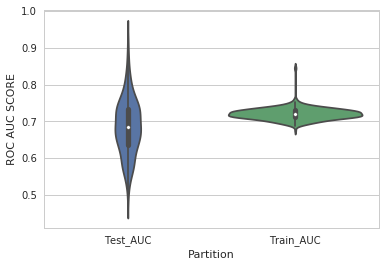

In [27]:
aucdf = pd.DataFrame({'Train_AUC':res['auc_train'], 'Test_AUC':res['auc_test']})
melted = pd.melt(aucdf, var_name="Partition", value_name='ROC AUC SCORE')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.violinplot(x="Partition", y='ROC AUC SCORE', data=melted)
plt.savefig("braincogscoreslg.png", dpi=300, bbox_inches='tight')

In [30]:
brain_cog_cols = np.array(brain_cog_cols)

In [31]:
from collections import Counter
def nonzero(x):
    return np.nonzero(x[0])[0]

cols = [brain_cog_cols[i] for i in [nonzero(res['coef_{}'.format(i)]) 
        for i in range(400)]]
cols = [v for q in cols for v in q ]
col_count = dict(Counter(cols))
col_count

{'SOPdomainAvgZ': 400,
 'VISPAdomainAvgZ': 5,
 'VLMdomainAvgZ': 400,
 'VWMdomainAvgZ': 400,
 'lhCortexVol': 42,
 'lh_Caudate': 1,
 'lh_Cerebellum.White.Matter': 2,
 'lh_G_Ins_lg_and_S_cent_ins_thickness_D': 1,
 'lh_G_and_S_cingul.Ant_thickness_D': 1,
 'lh_G_and_S_occipital_inf_thickness_D': 2,
 'lh_G_and_S_transv_frontopol_thickness_D': 2,
 'lh_G_cingul.Post.dorsal_thickness_D': 2,
 'lh_G_cingul.Post.ventral_thickness_D': 12,
 'lh_G_front_inf.Triangul_thickness_D': 10,
 'lh_G_insular_short_thickness_D': 1,
 'lh_G_oc.temp_lat.fusifor_thickness_D': 2,
 'lh_G_oc.temp_med.Parahip_thickness_D': 4,
 'lh_G_occipital_middle_thickness_D': 2,
 'lh_G_pariet_inf.Angular_thickness_D': 1,
 'lh_G_pariet_inf.Supramar_thickness_D': 2,
 'lh_G_precuneus_thickness_D': 2,
 'lh_G_rectus_thickness_D': 1,
 'lh_G_subcallosal_thickness_D': 2,
 'lh_G_temporal_inf_thickness_D': 1,
 'lh_G_temporal_middle_thickness_D': 1,
 'lh_Hippocampus': 2,
 'lh_Inf.Lat.Vent': 8,
 'lh_Lat_Fis.ant.Horizont_thickness_D': 227,
 'lh

In [87]:
cog_count = {key:val for key, val in col_count.items() if 'domainAvgZ' in key}
brain_count = {key:val for key, val in col_count.items()  if 'domainAvgZ' not in key}
cog_count_df = pd.DataFrame({'Feature':[key for key in cog_count.keys()],
                             'Times_Chosen':[val for val in cog_count.values()]})

In [88]:
cog_count_df.Feature = ['VLM', 'SOP', 'VISPA', 'VWM']
cog_count_df = cog_count_df.append(pd.DataFrame({'Feature':['RPS'], 'Times_Chosen':0}))
cog_count_df

,Feature,Times_Chosen
0,VLM,400
1,SOP,400
2,VISPA,5
3,VWM,400
0,RPS,0


In [86]:
pd.DataFrame({'Feature':['RPS'], 'Times_Chosen':0})

,Feature,Times_Chosen
0,RPS,0


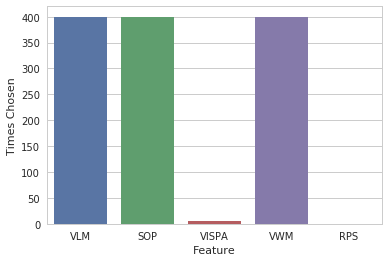

In [89]:
sns.barplot(x='Feature', y='Times_Chosen', data=cog_count_df)
#plt.xticks(rotation=70)
plt.ylabel("Times Chosen")
plt.savefig("Braicog_cogbar.png", dpi=300, bbox_inchex='tight')

In [90]:
y.mean()

0.36956521739130432

In [43]:
lh = {key.replace('lh_', '').replace('.', '-').replace('_thickness_D', ''):val for key, 
      val in brain_count.items() if 'lh' in key}
rh = {key.replace('rh_', '').replace('.', '-').replace('_thickness_D', ''):val for key, 
      val in brain_count.items() if 'rh' in key}

In [48]:
import pickle
def save_pickle(x, name):
    with open(name, "wb") as save:
        pickle.dump(x, save, protocol=pickle.HIGHEST_PROTOCOL)
    return None

In [49]:
save_pickle(lh, 'cogbrain_lh.pkl')
save_pickle(rh, 'cogbrain_rh.pkl')

In [50]:
pwd

u'/storage/gablab001/data/genus/GIT/genus/notebooks'

In [55]:
cog_data[five_scores]

,RPSdomainAvgZ,SOPdomainAvgZ,VISPAdomainAvgZ,VLMdomainAvgZ,VWMdomainAvgZ
0,-0.137259,0.261825,0.576001,-0.633401,0.317417
1,-0.596795,-0.244088,0.435217,-0.356669,-0.625201
2,0.970423,-0.155064,1.014507,-1.006689,0.371461
3,-0.667989,-0.081110,-0.300298,0.048958,0.626954
4,-0.315741,-0.523805,0.984547,-1.323432,-1.114922
5,0.318492,0.053449,1.236995,0.244592,0.687638
6,-0.652069,-0.636629,-0.776559,-0.992831,-0.631376
7,-0.045267,-0.372114,1.696646,-0.632695,-1.226413
8,-0.158079,0.044732,1.148695,-0.886437,0.311585
9,-1.127706,-0.877088,-0.291401,0.778301,-2.388255


In [56]:
XCR.shape

(368, 175)